In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# -----------------------------
# Entropy calculation
# -----------------------------
def entropy(y):
    values, counts = np.unique(y, return_counts=True)
    probs = counts / counts.sum()
    return -np.sum(probs * np.log2(probs + 1e-9))  # epsilon to avoid log(0)


# -----------------------------
# Information Gain
# -----------------------------
def information_gain(X_col, y):
    total_entropy = entropy(y)
    values, counts = np.unique(X_col, return_counts=True)
    weighted_entropy = 0
    for val, count in zip(values, counts):
        subset_y = y[X_col == val]
        weighted_entropy += (count / len(y)) * entropy(subset_y)
    return total_entropy - weighted_entropy


# -----------------------------
# Decision Node Class
# -----------------------------
class DecisionNode:
    def __init__(self, feature=None, children=None, is_leaf=False, prediction=None):
        self.feature = feature
        self.children = children or {}   # dict: value -> child node
        self.is_leaf = is_leaf
        self.prediction = prediction

    def to_dict(self):
        """Convert tree node to nested dict for readability/printing."""
        if self.is_leaf:
            return self.prediction
        return {self.feature: {val: child.to_dict() for val, child in self.children.items()}}


# -----------------------------
# Decision Tree Class
# -----------------------------
class DecisionTree:
    def __init__(self, max_depth=5, min_samples=2):
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.root = None
        self.target = None

    def fit(self, data, target):
        self.target = target
        self.root = self._build_tree(data, depth=0)

    def _build_tree(self, df, depth):
        y = df[self.target].values

        # Stopping criteria
        if (len(np.unique(y)) == 1 or
            len(df) < self.min_samples or
            depth >= self.max_depth):
            return DecisionNode(is_leaf=True, prediction=pd.Series(y).mode()[0])

        # Select best feature
        features = [col for col in df.columns if col != self.target]
        ig_scores = {f: information_gain(df[f].values, y) for f in features}
        best_feature = max(ig_scores, key=ig_scores.get)

        if ig_scores[best_feature] <= 0:
            return DecisionNode(is_leaf=True, prediction=pd.Series(y).mode()[0])

        # Split and recurse
        node = DecisionNode(feature=best_feature)
        for val in np.unique(df[best_feature]):
            subset = df[df[best_feature] == val]
            if subset.empty:
                child = DecisionNode(is_leaf=True, prediction=pd.Series(y).mode()[0])
            else:
                child = self._build_tree(subset, depth + 1)
            node.children[val] = child

        return node

    def predict_one(self, sample):
        node = self.root
        while not node.is_leaf:
            val = sample.get(node.feature)
            if val in node.children:
                node = node.children[val]
            else:
                return node.prediction  # fallback for unseen value
        return node.prediction

    def predict(self, X):
        return X.apply(lambda row: self.predict_one(row), axis=1)

    def to_dict(self):
        return self.root.to_dict()


# -----------------------------
# Example Usage
# -----------------------------
if __name__ == "__main__":
    # Load dataset
    data = pd.read_csv("dataset(National_Health_Interview_Surve).csv")
    target_col = "Category"

    # Drop irrelevant cols
    drop_cols = [
        'LocationAbbr', 'LocationDesc', 'DataSource', 'Data_Value_Unit',
        'Data_Value_Type', 'Data_Value_Footnote_Symbol', 'Data_Value_Footnote',
        'Numerator', 'LocationID', 'DataValueTypeID', 'GeoLocation',
        'Geographic Level', 'StateAbbreviation'
    ]
    data = data.drop(columns=drop_cols, errors="ignore")

    # Drop rows with missing target
    data = data.dropna(subset=[target_col])

    # Fill NaNs
    for col in data.columns:
        if col != target_col:
            if pd.api.types.is_numeric_dtype(data[col]):
                data[col] = data[col].fillna(data[col].median())
                # bin numeric into categories
                data[col] = pd.qcut(data[col], q=4, duplicates="drop").astype(str)
            else:
                data[col] = data[col].fillna("Unknown").astype(str)

    # Train tree
    tree = DecisionTree(max_depth=4, min_samples=5)
    tree.fit(data, target_col)

    # Print tree (dict view)
    print("\nDecision Tree Structure:")
    print(tree.to_dict())

    # Prediction example
    sample_dict = data.iloc[0].drop(target_col).to_dict()
    print("\nSample prediction:", tree.predict_one(sample_dict))


Decision Tree Structure:
{'Question': {'Percentage of adults ever told by a doctor or other health professional they had cataracts (NHIS Adult Module)': 'Self-Report Cataract', 'Percentage of adults ever told by a doctor or other health professional they had diabetic retinopathy (NHIS Adult Module)': 'Self-Report Diabetic Retinopathy', 'Percentage of adults ever told by a doctor or other health professional they had glaucoma (NHIS Adult Module)': 'Self-Report Glaucoma', 'Percentage of adults ever told by a doctor or other health professional they had macular degeneration (NHIS Adult Module)': 'Self-Report Age Related Macular Degeneration', 'Percentage of adults who are blind or unable to see at all (NHIS Adult Module)': 'Blind or Difficulty Seeing', 'Percentage of adults who currently wear eyeglasses or contact lenses (NHIS Adult Module)': 'Vision Correction', 'Percentage of adults who even when wearing glasses or contact lenses find it (not at all, only a little, somewhat, or very) d

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


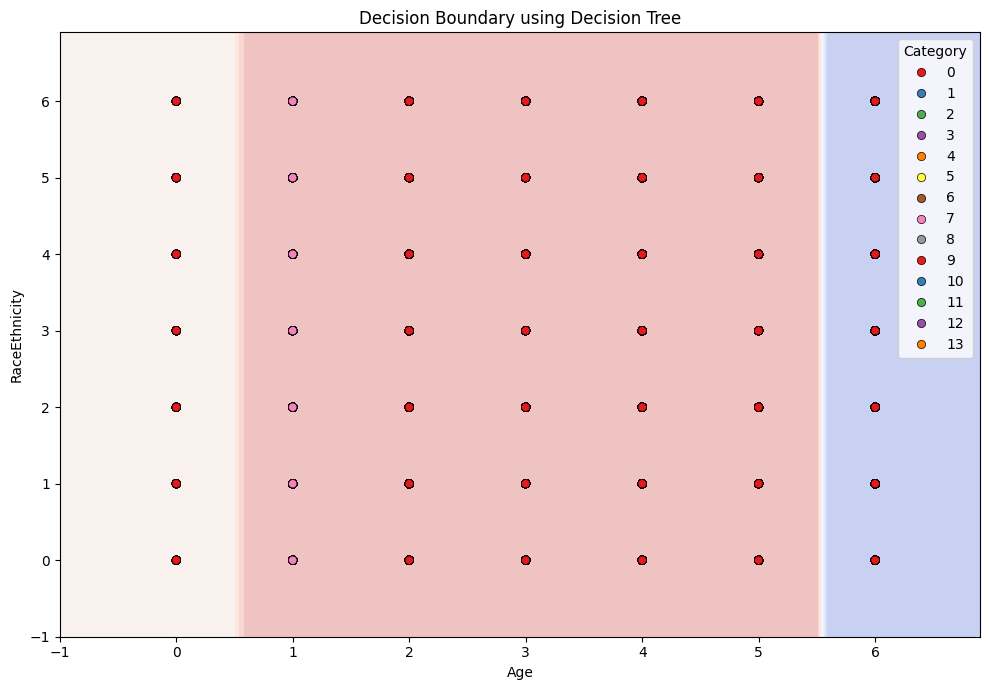

In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# -------------------
# Load dataset
# -------------------
df = pd.read_csv("dataset(National_Health_Interview_Surve).csv")

# Features and target
features = ['Age', 'RaceEthnicity']
target = 'Category'

# Encode categorical features and target
for col in features + [target]:
    if df[col].dtype == 'object':
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

X = df[features]
y = df[target]

# Train decision tree
dtc = DecisionTreeClassifier()
dtc.fit(X, y)

# Create meshgrid
x_min, x_max = df['Age'].min() - 1, df['Age'].max() + 1
y_min, y_max = df['RaceEthnicity'].min() - 1, df['RaceEthnicity'].max() + 1

xx, yy = np.meshgrid(
    np.arange(x_min, x_max, 0.1),
    np.arange(y_min, y_max, 0.1)
)

# Predict on grid
Z = dtc.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.figure(figsize=(10, 7))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
sns.scatterplot(
    x='Age', y='RaceEthnicity', hue=target,
    data=df, palette='Set1', edgecolor='k'
)
plt.xlabel('Age')
plt.ylabel('RaceEthnicity')
plt.title("Decision Boundary using Decision Tree")
plt.tight_layout()
plt.show()
